# 1. Introduction

## Guidelines
Please complete the assignment inside this notebook. Make sure the code can be executed easily.

- Write production-ready code.
- Create unit tests for your code where applicable.
- Add comments and documentation strings for all methods. Also discuss your design choices.
- Discuss the complexity (Big O notation) of your solutions, both memory wise and performance wise.
- Try to stick to the most popular scientific Python libraries.

## Input data
You should have received three csv files. Each csv-file represents the locations where a person was stationary for a certain amount of time. 
The csv-files contain the following fields:

- Latitude: The latitude of the detected GPS coordinates Longitude: The longitude of the detected GPS coordinates
- Timestamp: The start time of the stationary in the following format:
    - YYYY = year
    - MM = month of year
    - dd = day of month
    - HH=hourofday
    - mm = minute of hour
    - Z = timezone offset
- Duration: The length of time the person was stationary (in milliseconds)
    
All questions in this assignment are related to this data.

In [1]:
# import statements go here.
%matplotlib inline
import pandas as pd
import numpy as np

# 2. Programming skills

## Question 1: Data parsing
- Create the code needed to read and parse the data.
- Print out some summary statistics of the data
    - e.g. Average number of places visited per day
    - e.g. Median distance traveled between two subsequent stationary locations
    - ...

In [2]:
# parse data
person_converters = {'start_time(YYYYMMddHHmmZ)':pd.to_datetime}
person1 = pd.read_csv('person.1.csv', delimiter=';', converters=person_converters)
person2 = pd.read_csv('person.2.csv', delimiter=';', converters=person_converters)
person3 = pd.read_csv('person.3.csv', delimiter=';', converters=person_converters)

persons = person1.append([person2, person3])

## Count unique values in each column

In [3]:
# count unique values in each column
def count_uniq(col):
    return len(col.unique())



person1_uniq_cnt = person1.apply(count_uniq, axis=0)
person2_uniq_cnt = person2.apply(count_uniq, axis=0)
person3_uniq_cnt = person3.apply(count_uniq, axis=0)

unique_stat = pd.DataFrame([person1_uniq_cnt,person2_uniq_cnt,person3_uniq_cnt])
unique_stat.index.name = 'person'
unique_stat

,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms)
person,,,,
0,446,507,549,549
1,544,698,763,760
2,259,322,357,357


## Average number of places visited per day

In [4]:
def get_places_per_day_stat(person):
    places_per_day_person = person.groupby([person['start_time(YYYYMMddHHmmZ)'].dt.date])['latitude'].count()
    return places_per_day_person.describe()

In [5]:
table = pd.DataFrame({'person1': get_places_per_day_stat( person1 ), 
              'person2': get_places_per_day_stat( person2 ), 
              'person3': get_places_per_day_stat( person3 ),
              'allpersons': get_places_per_day_stat( persons )
             })

       allpersons    person1    person2    person3
count   90.000000  79.000000  90.000000  55.000000
mean    18.544444   6.949367   8.477778   6.490909
std     11.068897   5.396815   6.526055   3.905707
min      1.000000   1.000000   1.000000   1.000000
25%     12.250000   4.000000   5.000000   4.000000
50%     17.500000   5.000000   7.000000   6.000000
75%     23.000000   8.000000  10.000000   8.000000
max     78.000000  28.000000  45.000000  16.000000


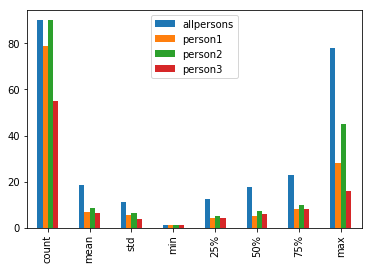

In [6]:
print(table)
table.plot(kind='bar')

## Median distance traveled between two subsequent stationary locations

In [7]:
# function to calculate distance
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [8]:
def dist_calc(person):
    dist = haversine_np(lon1=person1.longitude.shift(), 
                               lat1=person1.latitude.shift(),
                               lon2=person1.loc[1:, 'longitude'], 
                               lat2=person1.loc[1:, 'latitude'])
    return dist

In [9]:
# calculate distances
person1['dist'] = dist_calc(person1)
person2['dist'] = dist_calc(person2)
person3['dist'] = dist_calc(person3)

In [10]:
persons = person1.append([person2, person3])

In [11]:
# calc median distance between 2 locations
median_distance_between_2_locations = {'all': persons.dist.median(), 
 'person1': person1.dist.median(), 
 'person2': person2.dist.median(), 
 'person3': person3.dist.median()
 }

print('#median distance between 2 locations in km')
median_distance_between_2_locations

#median distance between 2 locations in km


{'all': 0.4752775147798534,
 'person1': 0.46483387710696955,
 'person2': 0.46483387710696955,
 'person3': 0.5069125481987093}

## Question 2: Data lookup
Create a method that generates a lookup table allowing us to effiently check whether or not a user has ever visited a location even if the new location is not exactly the same as the visited location (some noise is added to the longitude/latitude pairs).

In [12]:
from sklearn.neighbors import KDTree
import numpy as np
import logging

In [13]:
# use KD

In [14]:
class LookupTable:
    
    def __init__(self, persons):
        """
        Build lookupTable for each person

        """
        self.trees = {}
        location_field = ['latitude','longitude']
        for i, person in enumerate(persons):
            self.trees[i] = KDTree(person[location_field], leaf_size=2)
            
    def location_lookup(self, location, person_index, visited_loc=False, noise_distance_err = 0.1):
        
        """
        Check whether or not a user has ever visited a location 
        even if the new location is not exactly the same as the visited location 
        (some noise is added to the longitude/latitude pairs)
        
        location: [[latitude, lnongitude]] | the location to check
        person_index: int | index of person to check the visited location
        noise_distance_err: float | err of distance in km
        
        return 
            was_visited: Bool | location was ever visited or not
            visited_loc: [lat, lon] | visited location
            
            if visited_loc is False
                was_visited: Bool | location was ever visited or not
            else
                (was_visited, visited_loc)
        
        """
        ind = self.trees[person_index].query([location], k=1, return_distance=False)
        nearest_point = self.trees[person_index].get_arrays()[0][ind][0]
        
        distance = haversine_np(location[1], location[0], nearest_point[0][1], nearest_point[0][0])
        
        was_visited = distance <= noise_distance_err 

        return (was_visited, nearest_point) if visited_loc else was_visited

## do lookup

In [15]:
lookup_table = LookupTable([person1, person2, person3])

In [16]:
from random import random
location_field = ['latitude','longitude']

In [17]:
person1.loc[0,location_field].values

array([-49.326958000000005, -72.89073], dtype=object)

In [18]:
noise_lat = random() * 10 // 1 / 10  * 0.001
noise_lon = random() * 10 // 1 / 10  * 0.001

noise_lat, noise_lon

lookup_persons = person1.loc[0,location_field].values * 1000000 // 1 / 1000000
lookup_persons_noised = lookup_persons + [noise_lat, noise_lon]
lookup_persons_custom = lookup_persons + [1.0,0.0]

In [19]:
np.append( lookup_persons, [None, None] )

array([-49.326959, -72.89073, None, None], dtype=object)

In [20]:
# check location 0 from person1
print('check location person1')
print('check location 0: ', lookup_persons)
print('person1: ', lookup_table.location_lookup(lookup_persons, person_index=0) )
print('person2: ', lookup_table.location_lookup(lookup_persons, person_index=1) )
print('person3: ', lookup_table.location_lookup(lookup_persons, person_index=2) )

# check location 0 noised from person1
print('check location noised 0: ', lookup_persons_noised)
print('person1: ', lookup_table.location_lookup(lookup_persons_noised, person_index=0) )
print('person2: ', lookup_table.location_lookup(lookup_persons_noised, person_index=1) )
print('person3: ', lookup_table.location_lookup(lookup_persons_noised, person_index=2) )

# check location 0 custom from person1
print('check location custom 0: ', lookup_persons_custom)
print('person1: ', lookup_table.location_lookup(lookup_persons_custom, person_index=0) )
print('person2: ', lookup_table.location_lookup(lookup_persons_custom, person_index=1) )
print('person3: ', lookup_table.location_lookup(lookup_persons_custom, person_index=2) )

check location person1
check location 0:  [-49.326959 -72.89073]
person1:  True
person2:  False
person3:  False
check location noised 0:  [-49.326459 -72.88993]
person1:  True
person2:  False
person3:  False
check location custom 0:  [-48.326959 -72.89073]
person1:  False
person2:  False
person3:  False


# 3. Machine learning skills

## Question 1: Home and work detection
The goal of this question, is to design an algorithm that allows us to distinguish the likely home locations of a user from his likely work locations.

Note that a person might have multiple home and work locations, or might not have a work location at all. Also note that the data might be noise, incorrect and/or incomplete.

Discuss your choice of algorithms, rules, methods, distance measures, etc.

In [21]:
from sklearn.cluster import DBSCAN

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from itertools import chain

from sklearn import metrics

np.random.seed(0)

In [22]:
def extract_cluster_location_by_label(cluster_labels, labels, points, core_samples_mask ):

    locations = []
    
    print( cluster_labels )
    
    for _label in cluster_labels:
        
        class_member_mask = (labels == _label)
        xy = points[class_member_mask & core_samples_mask]
        
        locations.append( np.median( xy, axis=0 ) )
    
    return locations

In [23]:
# get person data and scan it for home|work locations

def dbscan_analize(pldata, eps=1.5, min_samples=10):
    
#     scaler = StandardScaler()
    
#     X = scaler.fit_transform(pldata[location_field].values)
    X = pldata[location_field].values
    
    kms_per_radian = 6371.0088
    epsilon = 0.05/kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
    cluster_labels = db.labels_

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    labels_true = labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    pldata['labels'] = labels
    
    # Calc how much time person was in point
    point_hours = pldata.groupby(['labels', person2['start_time(YYYYMMddHHmmZ)'].dt.hour])['duration(ms)'].sum()/1000

    # plot time graphs
    plot_cols = 3
    plot_rows = np.ceil(len(unique_labels)/plot_cols)
    
    plt.figure(figsize = (15,5))
    
    # extract home work positions
    home_possible = (-1, 0)
    work_possible = []
    for i, k in enumerate(unique_labels):
        plt.subplot(plot_rows, plot_cols, i+1)
        
        nduration = point_hours[k]/np.sum(point_hours[k])
        
        if k != -1:
            home_prop = nduration.loc[:6].sum()
            work_prop = nduration.loc[10:16].sum()
            work_possible.append( (k, work_prop ) )
            
            if home_possible[1] < home_prop:
                home_possible = (k, home_prop )

        plt.plot( nduration )
        plt.title('point: %s, %s' % (k,i+1))
    plt.show()
    
    
    
    work_possible = pd.DataFrame(work_possible)
    work_possible = work_possible[ work_possible[1] >= 0.2 ]
    work_possible.sort_values([1], ascending=False)
    
    if home_possible[0] in work_possible.loc[:,0].values:
        home_possible = None
        
    work_possible_locations = extract_cluster_location_by_label(cluster_labels=work_possible.loc[:,0].values,
                                      labels=labels, 
                                      points=X, 
                                      core_samples_mask=core_samples_mask )
        
    print( 'work_possible cluster num: ', work_possible.loc[:,0].values )
#     print( 'work_possible locations: ', work_possible_locations, scaler.inverse_transform(work_possible_locations) )
    print( 'work_possible locations: ', work_possible_locations, work_possible_locations) 
    
    home_possible_locations = extract_cluster_location_by_label(cluster_labels=[(home_possible[0] if home_possible else 'None')],
                                      labels=labels, 
                                      points=X, 
                                      core_samples_mask=core_samples_mask )
    
    print('home_possible cluster num: %s' % (home_possible[0] if home_possible else 'None'))
#     print('home_possible locations: ', home_possible_locations, scaler.inverse_transform( home_possible_locations ) )
    print('home_possible locations: ', home_possible_locations, home_possible_locations  )

    for k, col in zip(unique_labels, colors):
        if k == -1:        
            # Black used for noise.
            col = [0, 0, 0, 1]


        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]

        if xy.shape[0]:
            plt.annotate('%s' % (k), xy=xy[0], size=50)


        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=24)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
        
        

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    home_possible = home_possible[0] if home_possible else None
    silhouette = metrics.silhouette_score(X, labels)
    return silhouette, \
              n_clusters_, \
            (home_possible, home_possible_locations ), \
            (work_possible.loc[:,0].values, work_possible_locations )
    #         (home_possible, scaler.inverse_transform(home_possible_locations)), \
    #         (work_possible.loc[:,0].values, scaler.inverse_transform( work_possible_locations ) )

In [24]:
# get person data and scan it for home|work locations

def dbscan_analize(pldata, eps=0.1, min_samples=10):
    scaler = StandardScaler()
    
    X = scaler.fit_transform(pldata[location_field].values)

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    labels_true = labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    pldata['labels'] = labels
    
    # Calc how much time person was in point
    point_hours = pldata.groupby(['labels', person2['start_time(YYYYMMddHHmmZ)'].dt.hour])['duration(ms)'].sum()/1000

    # plot time graphs
    plot_cols = 3
    plot_rows = np.ceil(len(unique_labels)/plot_cols)
    
    plt.figure(figsize = (15,5))
    
    # extract home work positions
    home_possible = (-1, 0)
    work_possible = []
    for i, k in enumerate(unique_labels):
        plt.subplot(plot_rows, plot_cols, i+1)
        
        nduration = point_hours[k]/np.sum(point_hours[k])
        
        if k != -1:
            home_prop = nduration.loc[:6].sum()
            work_prop = nduration.loc[10:16].sum()
            work_possible.append( (k, work_prop ) )
            
            if home_possible[1] < home_prop:
                home_possible = (k, home_prop )

        plt.plot( nduration )
        plt.title('point: %s, %s' % (k,i+1))
    plt.show()
    
    
    
    work_possible = pd.DataFrame(work_possible)
    work_possible = work_possible[ work_possible[1] >= 0.2 ]
    work_possible.sort_values([1], ascending=False)
    
    if home_possible[0] in work_possible.loc[:,0].values:
        home_possible = None
        
    work_possible_locations = extract_cluster_location_by_label(cluster_labels=work_possible.loc[:,0].values,
                                      labels=labels, 
                                      points=X, 
                                      core_samples_mask=core_samples_mask )
        
    print( 'work_possible cluster num: ', work_possible.loc[:,0].values )
    print( 'work_possible locations: ', work_possible_locations, scaler.inverse_transform(work_possible_locations) )
    
    home_possible_locations = extract_cluster_location_by_label(cluster_labels=[(home_possible[0] if home_possible else 'None')],
                                      labels=labels, 
                                      points=X, 
                                      core_samples_mask=core_samples_mask )
    
    print('home_possible cluster num: %s' % (home_possible[0] if home_possible else 'None'))
    print('home_possible locations: ', home_possible_locations, scaler.inverse_transform( home_possible_locations ) )

    for k, col in zip(unique_labels, colors):
        if k == -1:        
            # Black used for noise.
            col = [0, 0, 0, 1]


        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]

        if xy.shape[0]:
            plt.annotate('%s' % (k), xy=xy[0], size=50)


        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=24)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
        
        

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    home_possible = home_possible[0] if home_possible else None
    silhouette = metrics.silhouette_score(X, labels)
    return silhouette, \
          n_clusters_, \
        (home_possible, scaler.inverse_transform(home_possible_locations)), \
        (work_possible.loc[:,0].values, scaler.inverse_transform( work_possible_locations ) )

In [25]:
def _filter_gps_noise1(location, person_index):
    visited = lookup_table.location_lookup(
        location, 
        person_index=person_index, 
        visited_loc=True,
        noise_distance_err=0.1 
    )
        
    if visited[0]:
        location = visited[1][0]
    
    return location

In [26]:
class HomeWorkScan:
    
    def __init__(self, persons):
        self.persons = persons
    

    def _extract_home_work_for_person(self, person, person_index):
        
        _person = person.copy()
        
        X = _person[location_field].values
        X_f1 = np.fromiter(chain.from_iterable(_filter_gps_noise1(i, person_index) for i in X), float)
        X_f1.shape = X.shape

        _person.loc[:,location_field] = X_f1
        _person = _person[ _person['duration(ms)'] >= _person['duration(ms)'].quantile(0.25) ]
        X_f1 = _person[location_field].values
        
        _, _, home_possible, work_possible = dbscan_analize(_person, eps=0.1)
        
        print(home_possible, work_possible)
        
        return {
            'home': home_possible,
            'work': work_possible
        }
    
    def extract_home_work(self):
        
        home_work = {}
        for i, person in enumerate( self.persons):
            print('-- home work person %s ---' % (i))
            _home_work = self._extract_home_work_for_person( person=person, person_index=i )
            home_work['person' + str(i)] = _home_work
            
        return home_work

In [27]:
c = HomeWorkScan(persons=[person1, person2, person3])

-- home work person 0 ---


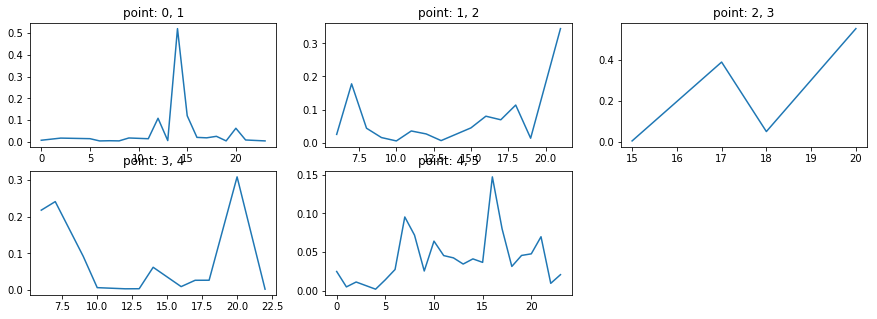

[0 4]
work_possible cluster num:  [0 4]
work_possible locations:  [array([-1.5216045 , -1.59772008]), array([0.67750817, 0.67952024])] [[-50.334595 -72.2639  ]
 [ 51.173332   4.363391]]
[3]
home_possible cluster num: 3
home_possible locations:  [array([-0.98628041, -1.07130012])] [[-25.624793 -54.550295]]


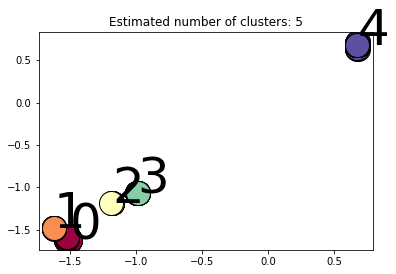

(3, array([[-25.624793, -54.550295]])) (array([0, 4], dtype=int64), array([[-50.334595, -72.2639  ],
       [ 51.173332,   4.363391]]))
-- home work person 1 ---


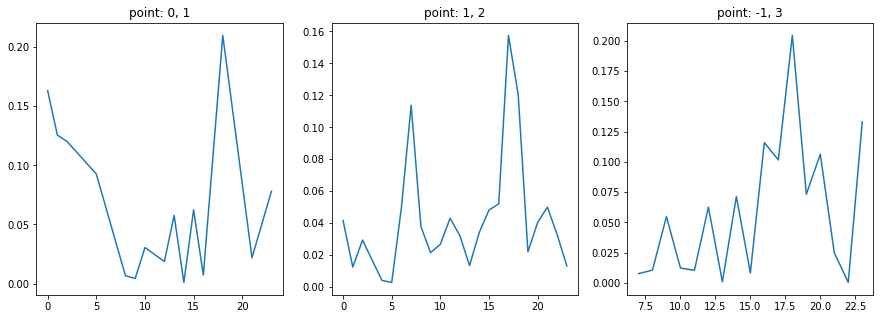

[1]
work_possible cluster num:  [1]
work_possible locations:  [array([0.35214187, 0.22390558])] [[51.21426    4.4076133]]
[0]
home_possible cluster num: 0
home_possible locations:  [array([-1.27384476, -2.41533433])] [[51.055416   3.7146337]]


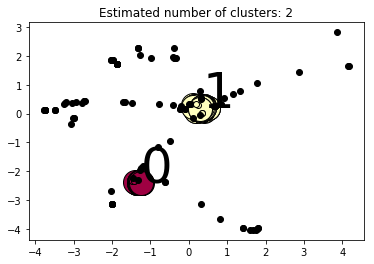

(0, array([[51.055416 ,  3.7146337]])) (array([1], dtype=int64), array([[51.21426  ,  4.4076133]]))
-- home work person 2 ---


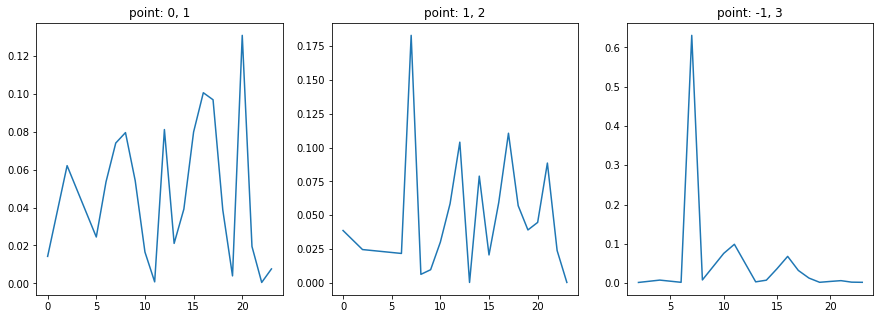

[0 1]
work_possible cluster num:  [0 1]
work_possible locations:  [array([ 1.01326269, -0.88497964]), array([-1.01701034,  1.27243823])] [[51.216297   4.394103 ]
 [50.95121    4.8899217]]
['None']
home_possible cluster num: None
home_possible locations:  [array([nan, nan])] [[nan nan]]


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


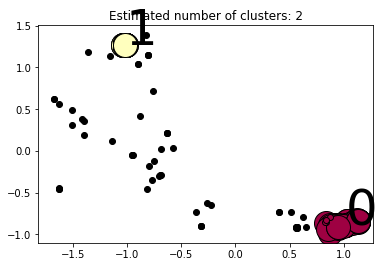

(None, array([[nan, nan]])) (array([0, 1], dtype=int64), array([[51.216297 ,  4.394103 ],
       [50.95121  ,  4.8899217]]))


In [28]:
home_work_locations = c.extract_home_work()

In [29]:
def plot_person_places(person, person_key):
    plt.scatter(person1[location_field].iloc[:,0], person1[location_field].iloc[:,1])
    plt.scatter(home_work_locations[person_key]['home'][1][:,0], home_work_locations[person_key]['home'][1][:,1], c='g')
    plt.scatter(home_work_locations[person_key]['work'][1][:,0], home_work_locations[person_key]['work'][1][:,1], c='r')
    plt.show()

In [30]:
home_work_locations

{'person0': {'home': (3, array([[-25.624793, -54.550295]])),
  'work': (array([0, 4], dtype=int64), array([[-50.334595, -72.2639  ],
          [ 51.173332,   4.363391]]))},
 'person1': {'home': (0, array([[51.055416 ,  3.7146337]])),
  'work': (array([1], dtype=int64), array([[51.21426  ,  4.4076133]]))},
 'person2': {'home': (None, array([[nan, nan]])),
  'work': (array([0, 1], dtype=int64), array([[51.216297 ,  4.394103 ],
          [50.95121  ,  4.8899217]]))}}

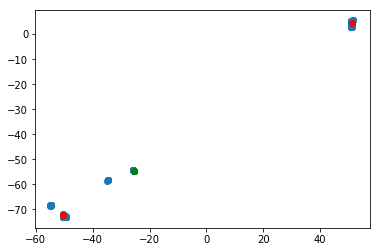

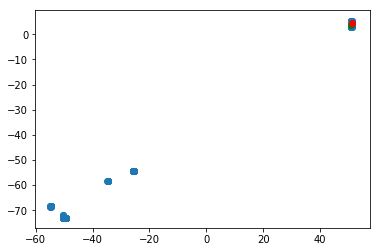

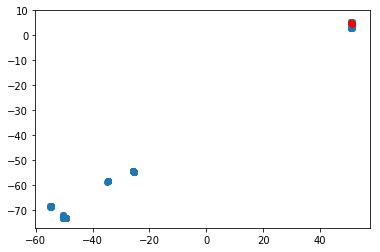

In [31]:
plot_person_places(person=person1, person_key='person0')
plot_person_places(person=person2, person_key='person1')
plot_person_places(person=person3, person_key='person2')

## Question 2: Social graph
- Try to uncover the geo-spatial similarities between the users' data. Do users visit similar places? Are they likely to know each other?
- Figure out a way to describe how 'socially active' each user is, by designing some kind of action radius metric. This metric should should take into account how many places a user visits, how far these places are away from each other, and how long the user stays there. The metric should allow us to compare users and to flag the most socially active one.

In [34]:
def series_coef(series):
    
    mean = series.mean()
    std = series.std()

    # for stability and predictability of coefficient simply filter values by +|- sigma
    # and filter by [0.1, 0.9] quantile
    ind_by_sigma = (series >= (mean - std )) & (series <= (mean + std ))
#     ind_by_quantile = (series >= series.quantile(0.1)) & (series <= series.quantile(0.9) )
    
    series = series[ ind_by_sigma ]
    
    mean = series.mean()
    std = series.std()

    # apply ABC Pareto strategy for coefficient (mode * 0.8 + 0.2 * (median * 0.8 + mean * 0.2))
    series_abc_pareto_X = series.mode()[0] * 0.8 + 0.2 * ( series.median() * 0.8 + mean * 0.2 )
    # apply var coefficient for simply norm predictability
    series_coef = series_abc_pareto_X / (std/mean)
    
    return series_abc_pareto_X, series_coef, std/mean

In [35]:
import logging
from sklearn import preprocessing
class SocialRating:
    
    '''
        Provide SocialRating for person and compare it with other
        person: 
            how many places user visit
            how far away places from each other 
            how long user stay there (in places)

            compare users and flag most social active one
    '''
    
    def __init__(self, person, verbose=False):
        
        '''
            person: pd.DataFrame
        '''
        self.person = person
        self._rating = None
        self.verbose = verbose
        
    def how_many_places_user_visit( self ):
        person = self.person
        
        places_per_day = person.groupby([person['start_time(YYYYMMddHHmmZ)'].dt.date])['latitude'].count()
        places_visit, places_visit_coef, var = series_coef( places_per_day )
        
        logging.info( (places_visit, places_visit_coef, var) )
    
        return places_visit, places_visit_coef, var
    
    def how_far_away_places_from_each_other( self ):
        person = self.person
        
        distance, distance_coef, var = series_coef( person.dist )        
        logging.info( (distance, distance_coef, var ) )
        
        return distance, distance_coef, var
    
    def how_long_user_stay_in_places( self ):
        person = self.person
        
        distance, distance_coef, var = series_coef( person['duration(ms)'] )        
        logging.info( (distance, distance_coef, var ) )
        
        return distance, distance_coef, var
    
    
    @property
    def rating( self ):
        
        '''
            Calculate rating for person
            rating = 
            how_many_places_user_visit 
            + how_far_away_places_from_each_other 
            + how_long_user_stay_in_places
        '''
        
        if not self._rating :
            
            how_many_places_user_visit = self.how_many_places_user_visit()
            how_far_away_places_from_each_other = self.how_far_away_places_from_each_other()
            how_long_user_stay_in_places = self.how_long_user_stay_in_places()
            
            # store how_* coefficients as is for future normalization
            self._rating = (
                how_many_places_user_visit[1], 
                how_far_away_places_from_each_other[1], 
                how_long_user_stay_in_places[1] 
            )
            
        logging.info( repr(self._rating ) )
            
        return self._rating
    
    def _rating_compare(self, other):
        
        variables_in_rating = len(self.rating ) 
        rating = pd.DataFrame( [self.rating, other.rating] ) 
        
        rating = rating/rating.sum( axis=0 )
        rating = np.round( rating.sum(axis=1)/variables_in_rating, 2 )
        
        logging.info( rating )
        return rating
    
    def __lt__(self, other):        
        ratingAB = self._rating_compare( other )
        return ratingAB[0] < ratingAB[1]

    def __le__(self, other):
        ratingAB = self._rating_compare( other )
        return ratingAB[0] <= ratingAB[1]

    def __eq__(self, other):
        ratingAB = self._rating_compare( other )
        return ratingAB[0] == ratingAB[1]

    def __ne__(self, other):
        return not self.__eq__(other)

    def __gt__(self, other):
        ratingAB = self._rating_compare( other )
        return ratingAB[0] > ratingAB[1]

    def __ge__(self, other):
        ratingAB = self._rating_compare( other )
        return ratingAB[0] >= ratingAB[1]

In [36]:
logging.basicConfig(
    format="%(asctime)-15s [%(levelname)s] %(funcName)s: %(message)s",
    level=logging.INFO)

In [37]:
sr1 = SocialRating(person=person1)
sr2 = SocialRating(person=person2)
sr3 = SocialRating(person=person3)

In [38]:
sr1 > sr2

2018-09-03 21:04:27,568 [INFO] how_many_places_user_visit: (4.217058823529412, 9.453039497189028, 0.446106125419597)
2018-09-03 21:04:27,576 [INFO] how_far_away_places_from_each_other: (0.26385781364250743, 0.08462569508734255, 3.1179396916052347)
2018-09-03 21:04:27,583 [INFO] how_long_user_stay_in_places: (260887.69853448283, 156723.30465132432, 1.6646388302933117)
2018-09-03 21:04:27,584 [INFO] rating: (9.453039497189028, 0.08462569508734255, 156723.30465132432)
2018-09-03 21:04:27,586 [INFO] rating: (9.453039497189028, 0.08462569508734255, 156723.30465132432)
2018-09-03 21:04:27,599 [INFO] how_many_places_user_visit: (5.321538461538462, 11.746579717417054, 0.4530287615251983)
2018-09-03 21:04:27,606 [INFO] how_far_away_places_from_each_other: (0.26385781364250743, 0.08462569508734255, 3.1179396916052347)
2018-09-03 21:04:27,612 [INFO] how_long_user_stay_in_places: (190767.74530487807, 111414.45873123848, 1.7122350857985225)
2018-09-03 21:04:27,613 [INFO] rating: (11.746579717417054

True

In [39]:
sr2 > sr3

2018-09-03 21:04:28,225 [INFO] rating: (11.746579717417054, 0.08462569508734255, 111414.45873123848)
2018-09-03 21:04:28,226 [INFO] rating: (11.746579717417054, 0.08462569508734255, 111414.45873123848)
2018-09-03 21:04:28,234 [INFO] how_many_places_user_visit: (4.391794871794872, 12.46683861582048, 0.3522781522351354)
2018-09-03 21:04:28,238 [INFO] how_far_away_places_from_each_other: (0.3458611590555225, 0.06836279897635339, 5.059201264932928)
2018-09-03 21:04:28,242 [INFO] how_long_user_stay_in_places: (214317.50181818186, 131090.31293921624, 1.634884355776588)
2018-09-03 21:04:28,243 [INFO] rating: (12.46683861582048, 0.06836279897635339, 131090.31293921624)
2018-09-03 21:04:28,246 [INFO] _rating_compare: 0    0.5
1    0.5
dtype: float64


False

In [40]:
!pip install joblib

In [41]:
from joblib import Parallel, delayed
from multiprocessing import cpu_count

class ProduceRating:
    
    def __init__(self, persons):
        
        self.persons = persons
        self._rating = None
        
    @property
    def rating(self):
        
        if not self._rating:
            def check_paths(person):
                return SocialRating(person=person).rating

            rating = Parallel(n_jobs=cpu_count()) (delayed(check_paths) (person) for person in self.persons )

            variables_in_rating = len(rating)

            logging.info( rating )

            rating = pd.DataFrame( rating ) 

            rating = rating/rating.sum( axis=0 )
            rating = np.round( rating.sum(axis=1)/variables_in_rating, 2 )
        
            self._rating = rating
        
        logging.info( rating )
        
        return rating

In [42]:
persons_rating = ProduceRating( persons=[person1, person2, person3]).rating

2018-09-03 21:04:37,687 [INFO] rating: [(9.453039497189028, 0.08462569508734255, 156723.30465132432), (11.746579717417054, 0.08462569508734255, 111414.45873123848), (12.46683861582048, 0.06836279897635339, 131090.31293921624)]
2018-09-03 21:04:37,691 [INFO] rating: 0    0.34
1    0.33
2    0.33
dtype: float64


In [43]:
print( persons_rating )

0    0.34
1    0.33
2    0.33
dtype: float64


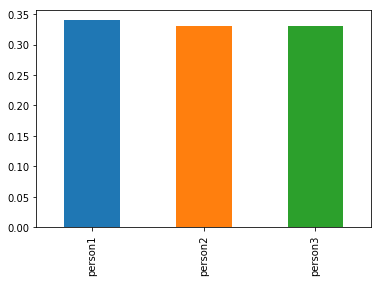

In [44]:
fig = persons_rating.plot(kind='bar');
fig.set_xticklabels(['person1', 'person2', 'person3']);